<a href="https://colab.research.google.com/github/barbaractong/motor-imagery/blob/main/classificador.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install mne

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 21.6 MB/s eta 0:00:00


In [3]:
import gdown
import glob
import math
import mne
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.signal as signal

from numpy.fft import fft
from scipy.io import loadmat

from sklearn.model_selection import cross_val_score # Cross Validation Function.
from sklearn.model_selection import KFold # KFold Class.

In [14]:
# download data from repository to colab - .mat files (1000Hz samples)
!gdown --folder https://drive.google.com/drive/u/2/folders/1bQEWkMRg-ag8rxFpquOjG5qr_fS963Fv

Retrieving folder list
Processing file 1taU1yDNwVZGnXZkeJIIn9FGyPjGQq5Bp BCICIV_calib_ds1a.mat
Processing file 1Wz6qBceL0AB0qQeDvy_ua8XSO2k8Fewi BCICIV_calib_ds1b.mat
Processing file 1HO0Y-0iQubkBFmBmTkZmEAdUvsClg6Vk BCICIV_calib_ds1c.mat
Processing file 1rRNM7h6GOXXIMU9FWUpyy9p6ExHBTPyf BCICIV_calib_ds1d.mat
Processing file 10u6sUJAsX5RapEnByHECZ6CmjGxLqfkr BCICIV_calib_ds1e.mat
Processing file 10EKUll5aOnwtBCWTsYYt5n_0omhHIg0O BCICIV_calib_ds1f.mat
Processing file 1gyOwuzNHUwG7tRXqZA6qRQlHUgTU0bJb BCICIV_calib_ds1g.mat
Retrieving folder list completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1taU1yDNwVZGnXZkeJIIn9FGyPjGQq5Bp
To: /content/calib/BCICIV_calib_ds1a.mat
100% 22.5M/22.5M [00:00<00:00, 108MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Wz6qBceL0AB0qQeDvy_ua8XSO2k8Fewi
To: /content/calib/BCICIV_calib_ds1b.mat
100% 22.5M/22.5M [00:00<00:00, 103MB/s]
Downloading...
From: https://drive.goo

### Dataset information
**Link**: https://www.bbci.de/competition/iv/desc_1.html

**Calibration data**:

In the **first two runs**, arrows pointing left, right, or down were presented as visual cues on a computer screen. **Cues were displayed for a period of 4s during which the subject was instructed to perform the cued motor imagery task.** These periods were interleaved with 2s of blank screen and 2s with a fixation cross shown in the center of the screen. The fixation cross was superimposed on the cues, i.e. it was shown for 6s. These data sets are provided with complete marker information.

**Dict description:**

Data are provided in Matlab format (*.mat) containing variables:

- cnt: the continuous EEG signals, size [time x channels]. The array is stored in datatype INT16. To convert it to uV values, use cnt= 0.1*double(cnt); in Matlab.
- mrk: structure of target cue information with fields (the file of evaluation data does not contain this variable)
  - pos: vector of positions of the cue in the EEG signals given in unit sample, length #cues
  - y: vector of target classes (-1 for class one or 1 for class two), length #cues
- nfo: structure providing additional information with fields
  - fs: sampling rate,
  - clab: cell array of channel labels,
  - classes: cell array of the names of the motor imagery classes,
  - xpos: x-position of electrodes in a 2d-projection,
ypos: y-position of electrodes in a 2d-projection.

## Data pre-processing

Loading the data from google drive. For this project, it will be loaded the 1000Hz data sample.

In [17]:
def load_mat_file(fpath):
  return loadmat(fpath, struct_as_record = True)

path = '/content/calib'
dataFiles = r''+path+'/*.mat'
files = glob.glob(dataFiles)
files.sort()

samples = [load_mat_file(f) for f in files]

In [18]:
len(samples)

7

In this step, it will be select only the tranning data that is from cue information to save the X_train matrix and the y_train vector.

In [19]:
X_train = []

In [20]:
for sample in range(0, len(samples)):
  for position in samples[sample]['mrk']['pos'][0][0][0]:
    X_train.append(samples[sample]['cnt'][position]*0.1) # Convert to Volt

In [21]:
X_train = np.vstack(X_train)

In [22]:
X_train.shape

(1400, 59)

In [23]:
y_train = []

In [24]:
for sample in range(0, len(samples)):
  y_train.append(samples[sample]['mrk']['y'][0][0][0])

In [25]:
y_train = np.hstack(y_train)

In [26]:
tranning_matrix = np.hstack((X_train,  y_train.reshape(-1, 1)))

- Reshape the matrix to separate into trials

In [27]:
X_train_by_trial = np.reshape(X_train, (200, 59, 7))

In [28]:
X_train_by_trial.shape

(200, 59, 7)

In [29]:
y_train_by_trial = np.reshape(y_train, (200, 7))

In [30]:
y_train_by_trial.shape

(200, 7)

- Time window for the data

In [31]:
def segmenting(data, seg_length, sample_rate):
  N_samples = data.shape[0]
  N_dims = len(data.shape)
  N_seg = seg_length*sample_rate
  start_seg = np.rint(np.arange(0, N_samples - N_seg + 1, N_seg)).astype(int)
  end_seg = (start_seg + np.rint(N_seg)).astype(int)

  for i in range(len(start_seg)):

    cut_data = data[start_seg[i]:end_seg[i],]
    expand_data = np.expand_dims(cut_data, N_dims)

    if i == 0:
      seg_data = expand_data
    else:
      seg_data = np.concatenate((seg_data, expand_data), N_dims)

  return seg_data

In [32]:
def segmenting_3d(data, seg_length, sample_rate):

  N_samples, N_channels, N_trials = data.shape
  N_class = 2
  N_dims = len(data.shape)
  N_seg = seg_length*sample_rate
  start_seg = np.rint(
      np.arange(0, N_samples*N_trials - N_seg + 1, N_seg)).astype(int)
  end_seg = (start_seg + np.rint(N_seg)).astype(int)

  for i in range(N_trials):

    if i == 0:

      cat_trials = data[:, :, i]

    else:

      cat_trials = np.concatenate((cat_trials, data[:, :, i]), axis=0)

  for i in range(len(start_seg)):

    cut_data = cat_trials[start_seg[i]:end_seg[i],]
    expand_data = np.expand_dims(cut_data, N_dims-1)

    if i == 0:

      seg_data = expand_data

    else:

      seg_data = np.concatenate((seg_data, expand_data), N_dims-1)

  return seg_data

- Testing the segmentation function

In [33]:
X_train_windowed = segmenting(X_train_by_trial, 0.01, 1000)

In [34]:
X_train_windowed.shape

(10, 59, 7, 20)

- Loading data parameters

In [35]:
# Checking if there is any data with a different sample rate
for s in samples:
  print(s['nfo']['fs'])

[[array([[100]], dtype=uint8)]]
[[array([[100]], dtype=uint8)]]
[[array([[100]], dtype=uint8)]]
[[array([[100]], dtype=uint8)]]
[[array([[100]], dtype=uint8)]]
[[array([[100]], dtype=uint8)]]
[[array([[100]], dtype=uint8)]]


In [36]:
sample_rate = samples[0]['nfo']['fs'][0][0][0][0] # Hz

In [37]:
print(f"Sample rate: {sample_rate} Hz")

Sample rate: 100 Hz


- Extracting given params

In [38]:
# Extract given param - Channel names
channel_id = [cid[0] for cid in samples[0]['nfo']['clab'][0][0][0]]

In [39]:
# Check the classes for all volunteers
classes_per_run = []
for s in samples:
  classes_per_run.append(s['nfo']['classes'][0][0][0])

print(classes_per_run)

[array([array(['left'], dtype='<U4'), array(['foot'], dtype='<U4')],
      dtype=object), array([array(['left'], dtype='<U4'), array(['right'], dtype='<U5')],
      dtype=object), array([array(['left'], dtype='<U4'), array(['right'], dtype='<U5')],
      dtype=object), array([array(['left'], dtype='<U4'), array(['right'], dtype='<U5')],
      dtype=object), array([array(['left'], dtype='<U4'), array(['right'], dtype='<U5')],
      dtype=object), array([array(['left'], dtype='<U4'), array(['foot'], dtype='<U4')],
      dtype=object), array([array(['left'], dtype='<U4'), array(['right'], dtype='<U5')],
      dtype=object)]


- Set the parameters

In [40]:
# Checking for the number of total samples
for s in samples:
  print(s['cnt'].shape)

(190594, 59)
(190594, 59)
(190549, 59)
(190473, 59)
(190329, 59)
(190608, 59)
(190602, 59)


## Run \#1 - 'T7', 'C5', 'C3', 'C1', 'CZ', 'C2', 'C4', 'C8', 'T8' channels

- Select only the channels that will be used to check motor stimulus

In [41]:
channels_for_model = []
labels = []
selected_channels = ['T7', 'C5', 'C3', 'C1', 'CZ', 'C2', 'C4', 'C8', 'T8']
for idx, c in enumerate(channel_id):
  if c in selected_channels:
    labels.append(c)
    channels_for_model.append(idx)

print(channels_for_model)
print(labels)

[24, 25, 26, 27, 29, 30, 32]
['T7', 'C5', 'C3', 'C1', 'C2', 'C4', 'T8']


- Get the data from X_train matrix

In [42]:
X_train_run_one = X_train_by_trial[:, channels_for_model, :]

In [43]:
X_train_run_one.shape

(200, 7, 7)

- Filter alpha and beta signal

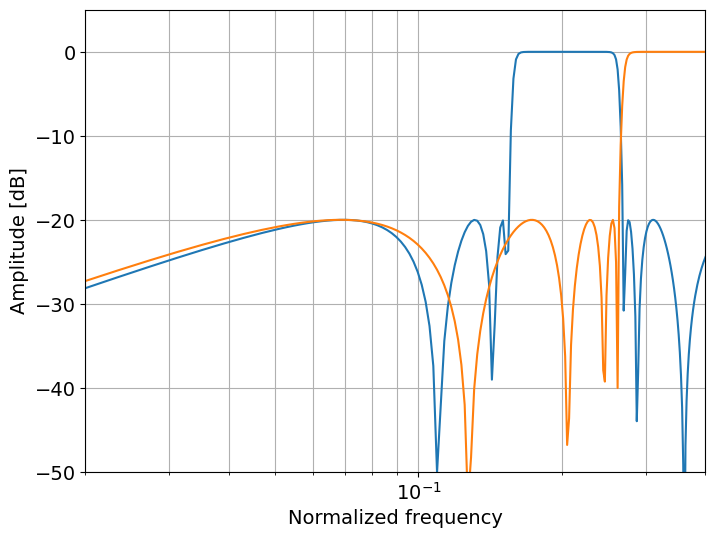

In [44]:
# alpha and beta filter - From article main: somatotopically matched sensorimotor 7–30 Hz rhythms were diminished over pericentral cortices.
sample_rate = 100
fp = np.array([[8, 13], [13.5, 30]])
fs = np.array([[7.5, 13.5], [13, 30.5]])
wp = fp/(sample_rate/2)
ws = fs/(sample_rate/2)

gpass = [1, 3]
gstop = 20

fig = plt.figure(figsize=(8, 6))
plt.rcParams.update({"font.size": 14})
ax = fig.add_subplot(1, 1, 1)

for i in range(wp.shape[0]):

  N, Wn = signal.cheb2ord(wp[i, :], ws[i, :], gpass[i], gstop)
  b, a = signal.cheby2(N, gstop, Wn, 'bandpass')
  w, h = signal.freqz(b, a)
  ax.semilogx(w/np.pi, 20*np.log10(abs(h)))

ax.set_xlabel('Normalized frequency')
ax.set_ylabel('Amplitude [dB]')
ax.grid(which='both', axis='both')
ax.axis([0.02, 0.4, -50, 5])
plt.show()

In [45]:
# fft comparing plot function
def fft_comparing_plot(data1, data2, f, ch_names, T, interval):

  print(data1.shape)
  print(data2.shape)

  N_channels = len(ch_names)
  fig = plt.figure(figsize=(12, 8))
  plt.rcParams.update({"font.size": 14})
  start_plot = math.floor(interval[0]*T)
  end_plot = math.floor(interval[1]*T)

  for i in range(N_channels):

    ax = fig.add_subplot(N_channels, 1, i + 1)
    ax.plot(f[start_plot:end_plot], data1[start_plot:end_plot, i])
    ax.plot(f[start_plot:end_plot], data2[start_plot:end_plot, i])
    ax.set_ylabel(ch_names[i])

    if(i==1):

      ax.set_xlabel('Frequency (Hz)')
      ax.legend(['Alfa', 'Beta'])

  plt.show()

- For all the trials, will be considered -1 as left and 1 as right

In [46]:
# Extract the last column containing labels
labels = tranning_matrix[:, -1]

# Create a boolean mask to filter rows with label equals -1
mask = (labels == -1)

# Use the mask to filter the original array
left_trials = tranning_matrix[mask][:, 0:59]

In [47]:
# Extract the last column containing labels
labels = tranning_matrix[:, -1]

# Create a boolean mask to filter rows with label equals -1
mask = (labels == 1)

# Use the mask to filter the original array
right_trials = tranning_matrix[mask][:, 0:59]

In [48]:
left_trials = left_trials.reshape(100, 59, 7)

In [49]:
right_trials = right_trials.reshape(100, 59, 7)

In [50]:
left_trials.shape

(100, 59, 7)

In [51]:
right_trials.shape

(100, 59, 7)

In [52]:
# alpha fft plot after filtering
N_alpha, Wn_alpha = signal.cheb2ord(wp[0, :], ws[0, :], gpass[0], gstop)
sos_alpha = signal.cheby2(N_alpha, gstop, Wn_alpha, 'bandpass', output='sos')

N_beta, Wn_beta = signal.cheb2ord(wp[1, :], ws[1, :], gpass[1], gstop)
sos_beta = signal.cheby2(N_beta, gstop, Wn_beta, 'bandpass', output='sos')

right_data = right_trials[:, channels_for_model, :]
alpha_right_hand = signal.sosfilt(sos_alpha, right_data, axis=0)
fft_alpha_right_hand = np.abs(fft(alpha_right_hand, axis=0))

left_data = left_trials[:, channels_for_model, :]
alpha_left_hand = signal.sosfilt(sos_alpha, left_data, axis=0)
fft_alpha_left_hand = np.abs(fft(alpha_left_hand, axis=0))

In [187]:
# feature extraction
right_data = segmenting_3d(right_trials[:, channels_for_model, :], 1.5, sample_rate)
alpha_right_hand = signal.sosfilt(sos_alpha, right_data, axis=0)
beta_right_hand = signal.sosfilt(sos_beta, right_data, axis=0)

left_data = segmenting_3d(left_trials[:, channels_for_model, :], 1.5, sample_rate)
alpha_left_hand = signal.sosfilt(sos_alpha, left_data, axis=0)
beta_left_hand = signal.sosfilt(sos_beta, left_data, axis=0)

log_var_alpha_right = np.log(np.var(alpha_right_hand, axis=0))
log_var_alpha_left = np.log(np.var(alpha_left_hand, axis=0))

log_var_beta_right = np.log(np.var(beta_right_hand, axis=0))
log_var_beta_left = np.log(np.var(beta_left_hand, axis=0))

In [188]:
log_var_alpha_left.shape

(7, 4)

In [189]:
# basic settings
N_samples, N_channels = samples[0]['cnt'].shape
N_samples = 100 # samples[0]['cnt'].shape[0]
T = N_samples/sample_rate
t = np.arange(0, T, 1/sample_rate)
f = np.arange(0, sample_rate, 1/T)

(100, 7)
(100, 7)


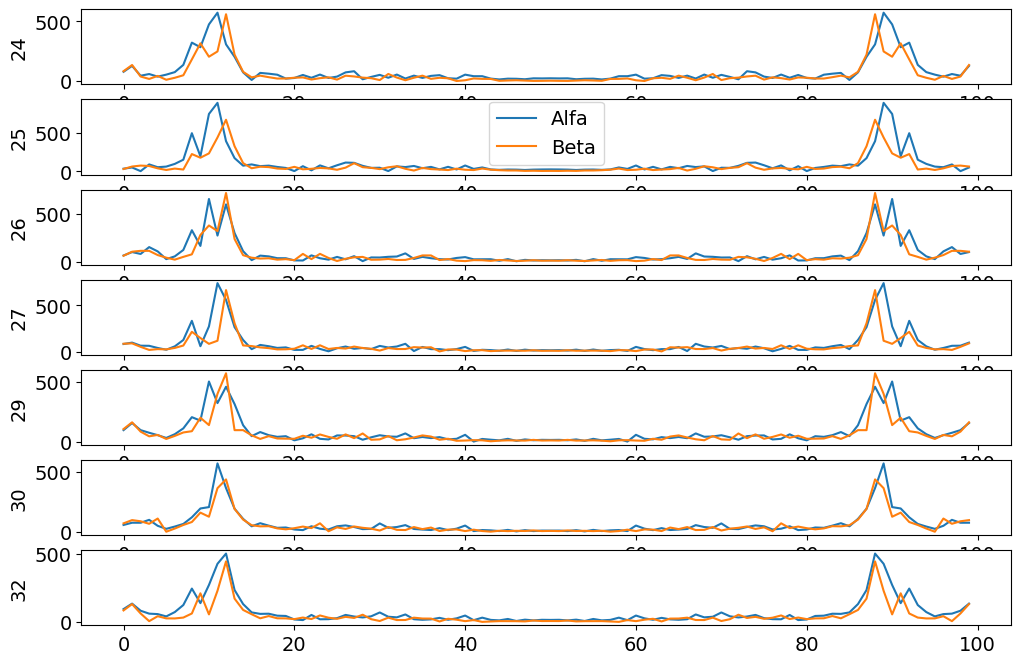

In [190]:
fft_comparing_plot(fft_alpha_right_hand[:, :, 1], fft_alpha_left_hand[:, :, 1], f, channels_for_model, T, [0, 1000])

In [191]:
# alpha and beta filters
N_alpha, Wn_alpha = signal.cheb2ord(wp[0, :], ws[0, :], gpass[0], gstop)
sos_alpha = signal.cheby2(N_alpha, gstop, Wn_alpha, 'bandpass', output='sos')
N_beta, Wn_beta = signal.cheb2ord(wp[1, :], ws[1, :], gpass[1], gstop)
sos_beta = signal.cheby2(N_beta, gstop, Wn_beta, 'bandpass', output='sos')

In [204]:
# preprossing
seg_data = segmenting_3d(X_train_by_trial[:, channels_for_model, :], 1.5, sample_rate)
alpha_seg_data = signal.sosfilt(sos_alpha, seg_data, axis=0)
beta_seg_data = signal.sosfilt(sos_beta, seg_data, axis=0)

# feature extraction
log_var_alpha = np.log(np.var(alpha_seg_data, axis=0))
log_var_beta = np.log(np.var(beta_seg_data, axis=0))

In [205]:
alpha_seg_data.shape

(150, 7, 9)

In [228]:
# kfold cross validation
kf = KFold(n_splits=5, shuffle=True)

In [229]:
log_var_alpha_left.shape

(7, 4)

In [230]:
def mount_attribute_matrix(log_var_alpha_left, log_var_beta_left, log_var_alpha_right, log_var_beta_right):

  # attribute matrix
  vstack_left_hand = np.vstack(
      (log_var_alpha_left[:, :], log_var_beta_left[:, :]))
  vstack_right_hand = np.vstack(
      (log_var_alpha_right[:, :], log_var_beta_right[:, :]))
  X = np.hstack((vstack_left_hand, vstack_right_hand))
  X = np.transpose(X)

  # label vector
  N_seg = log_var_alpha_left.shape[1]
  lv = np.hstack((np.ones(N_seg), -np.ones(N_seg)))

  # shuffle
  idx = np.arange(2*N_seg)
  np.random.shuffle(idx)
  X = X[idx,]
  lv = lv[idx,]

  return X, lv

In [231]:
mount_attribute_matrix(log_var_alpha_left, log_var_beta_left, log_var_alpha_right, log_var_beta_right)

(array([[5.9008735 , 5.71804463, 5.17944615, 4.89004849, 5.03683168,
         5.04584799, 5.14041963, 6.56831719, 6.74156247, 6.51125114,
         6.09733699, 6.3139282 , 6.20370594, 6.14026093],
        [5.60445846, 5.22582783, 6.50325497, 5.50747548, 5.7231918 ,
         5.75848191, 5.75095064, 6.81308422, 6.26862705, 8.61811412,
         6.13566814, 6.02277712, 6.40667594, 6.16048747],
        [5.63101004, 5.16908113, 5.11246657, 5.00069926, 4.8537289 ,
         4.68262119, 5.06143956, 6.20617276, 6.48260048, 6.56933614,
         6.25295776, 6.02856607, 6.23282672, 6.64329021],
        [5.69110316, 5.19667978, 5.28292887, 6.17360811, 5.12887922,
         5.03113329, 4.70540451, 6.57445329, 6.60332144, 6.1513439 ,
         6.54006367, 6.04470399, 5.97369808, 6.07218068],
        [6.21246255, 5.55726817, 4.93828664, 5.28290222, 5.35991114,
         5.16665497, 5.80847906, 6.84168963, 6.69236709, 6.26829688,
         6.41509051, 6.26004652, 5.81918981, 5.8235417 ],
        [5.71506428,

In [232]:
def linear_classifier_training(X, lv):

  X = np.hstack((np.ones((X.shape[0], 1)), X))
  w = np.matmul(np.linalg.pinv(X), lv)

  return w

In [233]:
def linear_classifier_predicting(X, w):

  X = np.hstack((np.ones((X.shape[0], 1)), X))
  g = np.matmul(X, np.transpose(w))

  return g

In [234]:
print(log_var_alpha.shape)

(7, 9)


In [235]:
for i, (train_idx, test_idx) in enumerate(kf.split(range(seg_data.shape[-1]))):

  print(i)

  # attribute matrix
  X_train, lv_train = mount_attribute_matrix(log_var_alpha_left, log_var_beta_left, log_var_alpha_right, log_var_beta_right)
  X_test, lv_test =mount_attribute_matrix(log_var_alpha_left, log_var_beta_left, log_var_alpha_right, log_var_beta_right)

  # classifier training
  w = linear_classifier_training(X_train, lv_train)

  # classfier predicting
  g = linear_classifier_predicting(X_test, w)

  # evaluating
  N_erros = len(np.where((np.sign(g) - lv_test) != 0)[0])
  rate = (X_test.shape[0] - N_erros)/(X_test.shape[0])

  if i == 0:

    cat_w = w
    cat_rate = rate

  else:

    cat_w = np.vstack((cat_w, w))
    cat_rate = np.hstack((cat_rate, rate))

0
1
2
3
4


In [236]:
X_train.shape

(8, 14)

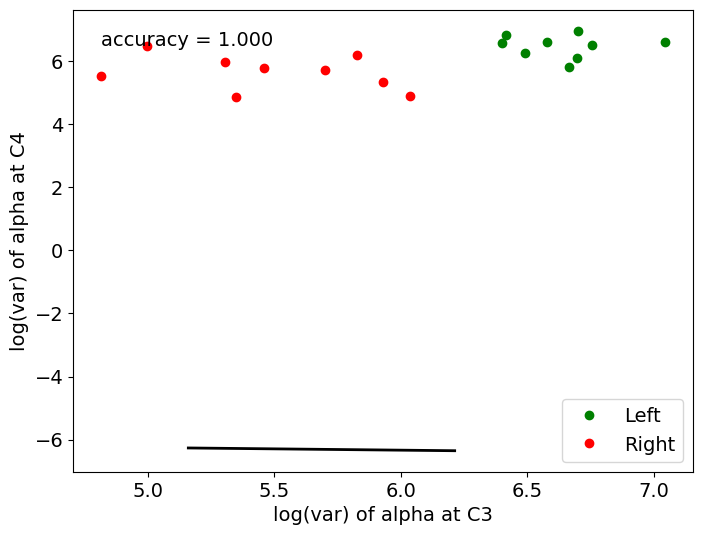

In [237]:
# projection of classifier boundary
x = np.linspace(np.min(X_train[:, [0, 1]]), np.max(X_train[:, [0, 1]]), 100)
z = np.mean(X_train[:, 0])
w = np.mean(X_train[:, 1])

for i in range(cat_w.shape[0]):

  a = -cat_w[i, 0]/cat_w[i, 1]
  b = -(cat_w[i, 0]*z + cat_w[i, 1]*w)/cat_w[i, 1]
  y = a*x + b

  if i == 0:

    cat_y = y

  else:

    cat_y = np.vstack((cat_y, y))

mean_y = np.mean(cat_y, axis=0)
mean_rate = np.mean(cat_rate, axis=0)

# alpha feature space after filtering
fig = plt.figure(figsize=(8, 6))
plt.rcParams.update({"font.size": 14})
ax = fig.add_subplot(1, 1, 1)
ax.plot(log_var_beta[0, :],
        log_var_beta[1, :], 'o', label='Left', color= 'g')
ax.plot(log_var_alpha[0, :],
        log_var_alpha[1, :], 'o', label='Right', color = 'r')

ax.plot(x, mean_y, linestyle='-', linewidth=2, color='k')
ax.set_xlabel('log(var) of alpha at C3')
ax.set_ylabel('log(var) of alpha at C4')
ax.text(np.min(log_var_alpha[0, :]), np.max(log_var_alpha[1, :]),
        r'accuracy = ' + '{:.3f}'.format(round(mean_rate, 3)))
ax.legend(loc='lower right')
plt.show()

In [74]:
# Data for three-dimensional scattered points
zdata = 15 * np.random.random(100)
xdata = np.sin(zdata) + 0.1 * np.random.randn(100)
ydata = np.cos(zdata) + 0.1 * np.random.randn(100)
ax.scatter3D(xdata, ydata, zdata, c=zdata, cmap='Greens');

AttributeError: ignored

In [ ]:
!gdown --folder https://drive.google.com/drive/folders/18hjiMDJdMB_Hd2EeYOaWx38dKqxyIuNi

Retrieving folder list
Processing file 1HpdhmxHzADsURU68JLGh9n5s7-x8PQly BCICIV_eval_ds1a_1000Hz.mat
Processing file 1rj8ZDHgWDOevPTLHsBuMQmaTRHmyZViy BCICIV_eval_ds1b_1000Hz.mat
Processing file 1-dhuy5UINOw3P7rcYJdhHPAeAWh2ohF8 BCICIV_eval_ds1c_1000Hz.mat
Processing file 1SScGUhnGZqEKkUBpwkS7Ij45xSQjtKwe BCICIV_eval_ds1d_1000Hz.mat
Processing file 1rqMfRPConiPwq_-pqMrEAHLsaw_kfMpv BCICIV_eval_ds1e_1000Hz.mat
Processing file 1L5bTK_YUYoh77Zg8JDfSUY2b55i8IGLd BCICIV_eval_ds1f_1000Hz.mat
Processing file 1KlbFYUREru3GD2UH81cb2NIIVmn5Br1C BCICIV_eval_ds1g_1000Hz.mat
Retrieving folder list completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1HpdhmxHzADsURU68JLGh9n5s7-x8PQly
To: /content/BCICIV_1eval_1000Hz_mat/BCICIV_eval_ds1a_1000Hz.mat
100% 208M/208M [00:03<00:00, 51.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1rj8ZDHgWDOevPTLHsBuMQmaTRHmyZViy
To: /content/BCICIV_1eval_1000Hz_mat/BCICIV_eval_ds1b_

In [ ]:
# test data
path = '/content/BCICIV_1eval_1000Hz_mat'
dataFiles = r''+path+'/*.mat'
files = glob.glob(dataFiles)
files.sort()

test_samples = [load_mat_file(f) for f in files]

In [ ]:
test_samples[0]['cnt']

array([ -55, -158, -373, -372,  -61, -258, -141, -258, -140, -553,  307,
        -59, -309, -251, -420,  230,  277,  424, -343, -171, -378, -381,
       -387, -333,  122,  257, -222, -170, -409, -406, -332, -444, -165,
        -22, -179, -139, -341, -416, -303, -496, -280, -105, -372, -424,
       -317, -447, -354, -246, -178, -248, -411, -359, -311, -381, -299,
       -267, -386, -318, -295], dtype=int16)

In [ ]:
X_test = []

In [ ]:
for sample in test_samples:
  X_test.append(sample['cnt']*0.1) # Convert to Volt

In [ ]:
X_test = np.vstack(X_test)